# A logistic regressor for two synthetic clusters of vectors

<a target="_blank" href="https://colab.research.google.com/github/jaspock/me/blob/main/notebooks/model_monitoring.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Code written by Juan Antonio Pérez in 2023.

This notebook presents a simple example of a logistic regressor trained to classify two clusters of vectors. The goal is to explore the code needed to train a model using very basic low-level PyTorch and moving to higher-level functions later.

To make the problem easy for a logistic regressor, let's consider a simplified scenario in which inputs are vectors of size 2 which may belong to one of two classes. To bring this abstraction closer to the realm of natural language processing, you may think of each input vector as an extremely tiny embedding representing a sentence, and already computed by some other module. The two output classes determine whether the sentence sentiment is positive (1) or negative (0). Note that although these values of 0 and 1 will be used as the desired output during training, the logistic regressor will output a value in between. Here, we will train a logistic regressor to classify the sentences in the training set and then use the resulting model to obtain the sentiment of a new sentence.


## Installation of dependencies

First, we need to install the dependencies. 

In [77]:
!pip install matplotlib numpy torch transformers scikit-learn

16569.42s - pydevd: Sending message related to process being replaced timed-out after 5 seconds




## Generating the data

In order to have the situation under control, we will not explicitly obtain the embeddings from a set of sentences, but make the problem easier by randomly generating the bidimensional vectors for each class following a normal distribution with a specific mean (center) and standard deviation. The standard deviation is a measure of how spread out vectors are. When generating data under a normal distribution, a standard deviation of σ implies that roughly 68% of the data falls within ±σ of the mean. When generating our vectors, each component of the bidimensional vector is generated independently around the corresponding component of the mean and follows a normal distribution with the same standard deviation σ.

The following code generates the data for the two classes using the `scikit-learn` library and its function `sklearn.datasets.make_blobs`. This function returns a tuple containing the generated data and the corresponding labels starting with 0 for the first class. The `random_state` parameter is used to make the generation reproducible by providing a seed to the random number generator. The code then plots the data using the `matplotlib` library and its function `matplotlib.pyplot.scatter` that plots a set of points in a bidimensional space. 

Note that the package name for `pip` is `scikit-learn`, but the module to be imported is called `sklearn`. `sklearn.datasets.make_blobs` returns the data as `numpy.ndarray` objects that represent the basic class for vectors and matrices in the library NumPy. We can access the first component of the matrix `X` by using `X[0,0]` or alternatively `X[0][0]`. We may also use the slicing operator `:` to access a subset of the matrix: for example, `X[5:10]` returns the rows from 5 to 9, and `X[:,0]` returns the first column. We will see later that in PyTorch the slicing operator can also be used to access parts of a tensor.

You may play with the `dev` variable to see how data is spread out around the means.

**Documentation:** [sklearn.datasets.make_blobs](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html), [matplotlib.pyplot.scatter](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html), [numpy.ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html)

type(Xn) = <class 'numpy.ndarray'>, type(yn) = <class 'numpy.ndarray'>
Xn.shape = (100, 2)
yn.shape = (100,)
Xn[:3] = [[ 0.44252015  3.35882143]
 [-0.21116809  4.67567271]
 [ 4.81611633  6.46479701]]
yn[:3] = [0 0 1]


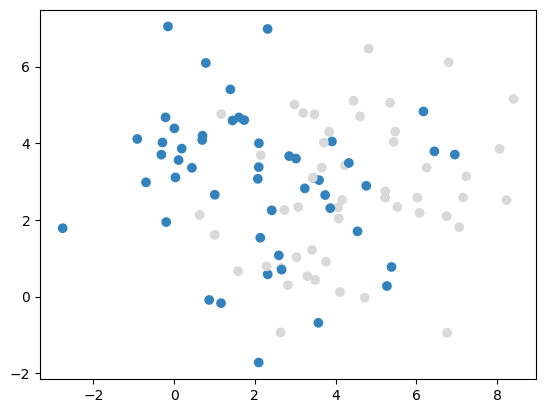

In [78]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt

class_centers = [[2,3], [4,3]]
dev = 2
samples = 100
features = 2

Xn, yn = make_blobs(n_samples=samples, centers=class_centers, cluster_std=dev, n_features=features, random_state=4)

print(f"type(Xn) = {type(Xn)}, type(yn) = {type(yn)}")
print(f"Xn.shape = {Xn.shape}")  # bidimensional array
print(f"yn.shape = {yn.shape}")  # unidimensional array
print(f"Xn[:3] = {Xn[:3]}")  # first three samples
print(f"yn[:3] = {yn[:3]}")  # 0 for the first class, 1 for the second class

plt.scatter(Xn[:,0], Xn[:,1], c=yn, cmap='tab20c')  # cmap is the color map
plt.show()

## Inititalizing tensors

CPUs are designed for general-purpose computing, handling a wide range of tasks, but they typically process tasks sequentially. On the other hand, GPUs are specialized for parallel processing, making them highly efficient for computations that can be performed simultaneously, such as those in deep learning. Therefore, switching from NumPy to PyTorch is essential for tasks that can benefit from the parallel processing capabilities of GPUs. While NumPy is efficient for CPU-based computing, PyTorch provides the necessary infrastructure to efficiently harness the power of GPUs, making it a superior choice for GPU-accelerated computing tasks.

Our logistic regressor and the data sizes are so small that we will not see any difference in performance between NumPy and PyTorch. However, we will use PyTorch to get familiar with its tensors and operations before moving to more complex models. Luckily, conversion is straightforward as PyTorch has factory methods (such as `torch.from_numpy`) that accept NumPy arrays as arguments and return objects of class `torch.Tensor`. Note that `torch.from_numpy` is strictly not a constructor, but a factory function. It actually returns a tensor that shares the same CPU memory with the NumPy array; as a result of that, the returned tensor is not resizable.

NumPy arrays use double precision (64 bits) by default, while PyTorch tensors use single precision (32 bits) by default. This is because GPUs are faster with single-precision (FP32) calculations, and the difference in precision is usually negligible. Moreover, some GPUs do not natively support double precision (FP64) and must emulate it which is even slower. Consequently, we first convert NumPy arrays to single-precision before converting them to PyTorch tensors. Tensors are initially created on the CPU, and can then be moved to the GPU by calling the `Tensor.to` method; note that this method returns a new tensor and does not modify the original one. We detect whether a GPU is available by checking the value of `torch.cuda.is_available`; if no GPU is available, we use the CPU instead. The name `cuda:0` refers to the first GPU device, if available. In PyTorch, the result of any operation will be on GPU, only if all the arguments are on GPU. 

Note that we overwrite the original NumPy arrays with the converted tensors. This is because we will not use the NumPy arrays anymore. Consequently, they may be garbage collected and their CPU memory reused by the system.

In [79]:
import numpy as np
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"  # global variable
print (f'Using {device}')

X = torch.from_numpy(np.float32(Xn)).to(device)
y = torch.from_numpy(np.float32(yn)).to(device)

print(f"type(X) = {type(X)}, type(y) = {type(y)}")
print(f"X.shape = {X.shape}")
print(f"y.shape = {y.shape}")
print(f"X[:3] = {X[:3]}")
print(f"y[:3] = {y[:3]}")

Using cpu
type(X) = <class 'torch.Tensor'>, type(y) = <class 'torch.Tensor'>
X.shape = torch.Size([100, 2])
y.shape = torch.Size([100])
X[:3] = tensor([[ 0.4425,  3.3588],
        [-0.2112,  4.6757],
        [ 4.8161,  6.4648]])
y[:3] = tensor([0., 0., 1.])


## Splitting the data into training and test sets

We will split the data into training and test sets. The training set will be used to train the model, while the test set will be used to evaluate the model performance on unseen data. Usually, the test set is much smaller than the training set and made of a few hundred or thousand samples. In this case, we will use one in every three samples for testing, and the rest for training. Note that we are not using a validation set in this notebook, but we will see how to do it later.

The splitting procedure is carried out by a creating a mask filled with zeros except for every third element, which is set to one to indicate that the corresponding sample should be used for testing. Selection of items according to the mask is done via advanced indexing that occurs when an integer or boolean tensor is used to index another tensor. See in the code a simple example of this indexing technique. See afterwards how the mask is used to split the data into training (`X_train`, `y_train`) and test (`X_test`, `y_test`) sets.

As we want a tensor of ones with the same size as the number of rows in `X`, we use `X.shape[0]`, that is, the size of the first dimension of `X`, instead of the actual number of rows so that the code is more general and automatically adapts to changes in the shape of `X`. 

Note that we link the documentation for advanced indexing of *ndarrays* on NumPy, as tensors in PyTorch are very similar to them and PyTorch's documentation does not include an explicit section on advanced indexing.

*Documentation:* advanced [indexing](https://numpy.org/doc/stable/user/basics.indexing.html#advanced-indexing) in NumPy, [torch.arange](https://pytorch.org/docs/stable/generated/torch.arange.html), [torch.ones](https://pytorch.org/docs/stable/generated/torch.ones.html), [torch.logical_not](https://pytorch.org/docs/stable/generated/torch.logical_not.html).

In [80]:
# example of advanced indexing with tensors of booleans and integers:
a = torch.arange(5)  # generates a tensor with values from 0 to 4
a = a * 10  # multiplies each element by 10
print(f"a = {a}")
i = torch.tensor([True, False, True, False, True])
print(f"a[i] = {a[i]}")  # selects the elements corresponding to True
j = torch.tensor([0, 2, 4])
print(f"a[j] = {a[j]}")  # selects the elements at the given indices


a = tensor([ 0, 10, 20, 30, 40])
a[i] = tensor([ 0, 20, 40])
a[j] = tensor([ 0, 20, 40])


In [81]:
# create train/test views of the data:
mask = torch.ones(X.shape[0], dtype=bool).to(device)
mask[::3] = 0  # one every 3 elements for testing
X_train, y_train = X[mask], y[mask]
X_test, y_test = X[torch.logical_not(mask)], y[torch.logical_not(mask)]
# print shspe of all tensors:
print(f"X_train.shape = {X_train.shape}")
print(f"y_train.shape = {y_train.shape}")
print(f"X_test.shape = {X_test.shape}")
print(f"y_test.shape = {y_test.shape}")

X_train.shape = torch.Size([66, 2])
y_train.shape = torch.Size([66])
X_test.shape = torch.Size([34, 2])
y_test.shape = torch.Size([34])


## Auxiliary functions

We define a series of auxiliary functions that will be used later:

- `regressor` initializes and returns the parameters of the model, that is, the weight vector $\mathbf{w}$ and the bias term $b$. 
- `sigmoid`: returns a tensor in which each element is the sigmoid of the corresponding element in the input tensor; this will be called by the logistic regressor to obtain the output of the model. Recall that if the input is a single sample, the equation is $\hat{y} = \text{sigmoid}(\mathbf{x}\mathbf{w} + b)$.
- `forward`: returns the output of the logistic regressor for a given input tensor, that is, $\hat{y}$ in the previous formula.
- `binary_cross_entropy`: returns the binary cross-entropy loss for a given output tensor and the corresponding desired output; recall that if $N$ is the number of samples in the *mini-batch* (see below) this is computed as 
$$
\mathcal{L} = -\frac{1}{N}\sum_{i=1}^N y_i\log(\hat{y}_i) + (1-y_i)\log(1-\hat{y}_i).
$$

A few words on the use of mini-batches: in deep learning, the training and inference procedures do not proceed sample by sample, but rather in the so called *batches* (sets) of samples. This is because GPUs are more efficient when processing batches of data and because training at sample level is too slow and unstable. The size of the batch is usually chosen to fill the GPU memory. In this notebook, we will simplify this and feed the whole training and test sets to the model assuming that they will fit in the GPU memory because our model is extremely simple and the data is very small. We will see later how to use mini-batches in PyTorch. 

Working with mini-batches has an important implication for most of our functions. For example, the input to the regression model in the `forward` function will be a tensor of size `(batch_size, 2)`, and the output will be a tensor of size `(batch_size, 1)`. Similarly, the `sigmoid` function will not work on vectors of size 2 as we might expect, but on collections (batches) of these vectors, that is, on bidimensional tensors of shape `(batch_size, 2)`.  Luckily, PyTorch is designed to work with tensors of arbitrary shapes and already assumes that the first dimension corresponds to the batch size. Matrix multiplication, for example, is performed by the `torch.matmul` function, which expects two tensors of arbitrary shapes and performs matrix multiplication on the last two dimensions. For example, if `a` is a tensor of shape `(3, 4, 5)` and `b` is a tensor of shape `(3, 5, 6)`, then `torch.matmul(a, b)` returns a tensor of shape `(3, 4, 6)` which contains the 3 matrices resulting from the independent multiplication of the 3 matrices of shape `(4, 5)` and `(5, 6)` in `A` and `B`, respectively.

If the input to the regressor model is not a single vector anymore, but a bidimensional tensor, then the dot product has to be performed between each of the input tensors $\mathbf{x}_i$ and the unique weight vector $\mathbf{w}$. In principle, you may think this can be done via a kind of loop, but loops are generally terrible in terms of performance in PyTorch. Luckily enough,  the `torch.matmul` operation that we would use to perform conventional matrix multiplication is also able to efficiently perform the dot product between each row in the input matrix and the weight vector to obtain a tensor of shape `(batch_size, 1)` as done in the `forward` function.   

Another important implementation detail is that of the addition of the bias term in the `forward` function. In our code, the bias term is a scalar represented with a tensor of shape `(1)`, but it is added to a tensor of shape `(batch_size, 1)`. This does not make sense in terms of tensor addition, but PyTorch automatically *broadcasts* the scalar to a tensor of shape `(batch_size, 1)` by duplicating it as many times as necessary and then performs the addition. Broadcasting is a mechanism that allows efficient operations between tensors of different shapes and we will find it many times when working with PyTorch. Also, note how the `+` operator has been overloaded to perform the addition of tensors; an equivalent expression would use the `torch.add` function.

Scalars could also be represented with tensors of shape `()`, that is, tensors without dimensions, but we have chosen to represent them with tensors of shape `(1)` to make the code easier to read.

Documentation: [torch.exp](https://pytorch.org/docs/stable/generated/torch.exp.html), [torch.matmul](https://pytorch.org/docs/stable/generated/torch.matmul.html), [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) in Numpy, [torch.sum](https://pytorch.org/docs/stable/generated/torch.sum.html), [torch.log](https://pytorch.org/docs/stable/generated/torch.log.html), [torch.add](https://pytorch.org/docs/stable/generated/torch.add.html)

In [82]:
def regressor(size):
    weights = torch.rand(size, dtype=torch.float32).to(device)
    bias = torch.rand(1, dtype=torch.float32).to(device)
    return weights, bias

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def forward(X, weights, bias):
    return sigmoid(torch.matmul(X,weights) + bias)  # bias is broadcasted to (batch_size)

def binary_cross_entropy(y_truth, y_pred):
    m = 1 / y_truth.shape[0]  # y_truth.shape[0] is the size of the mini-batch
    return -m * (y_truth * torch.log(y_pred) +
                    (1 - y_truth) * torch.log(1 - y_pred)).sum()

## Training the model

We are now ready to train the model. We encapsulate the training procedure in a function `train` that receives the mini-batched input data, the corresponding desired outputs, the randomly initialized weight vector and bias term, the learning rate, the number of steps to perform, and the number of steps between two consecutive evaluations of the model. The function returns the trained weight vector and bias term, and the loss for the input data after the last training step.

We also add a couple of functions to compute the gradients and update the parameters of the model. This functions are very small and their code could have been easily included in the `train` function, but we have decided to separate them so that you get used to their existence and names which will be used later in more complex models.

The function `train` iterates over the training steps and for each step it computes the output of the model (via `forward`), and the gradients (via `loss_backward`). The gradients are then used to update the parameters of the model via `optimizer_step`. Every `it_log` steps, the mean loss for the training set is computed and printed. Note that computation of the binary cross-entropy loss is not strictly necessary for the training algorithm, but it is useful for the developers to monitor the training process and detect possible problems. What the stochastic gradient descent (SGD) algorithm really needs is the gradient of the loss with respect to the parameters of the model, which is computed by the `loss_backward` function.

In the `loss_backward` function, the `*` operator calls the `torch.mul` function that performs element-wise multiplication with broadcasting.

You could carefully check that the gradients computed by the `loss_backward` function match those that you would compute by hand.

Documentation: [torch.mul](https://pytorch.org/docs/stable/generated/torch.mul.html)

In [83]:
def loss_backward(y_truth, y_pred, X):
    err = (y_pred - y_truth)
    grad_w = (1 / y_truth.shape[0]) * torch.matmul(err, X)
    grad_b = (1 / y_truth.shape[0]) * torch.sum(err)
    return grad_w, grad_b

def optimizer_step(weights, bias, grad_w, grad_b, lr=0.01):
    weights = weights - lr * grad_w
    bias = bias - lr * grad_b
    return weights, bias

def train(X, y_truth, weights, bias, lr=0.01, steps=1000, steps_log=100):
    for i in range(steps):
        y_pred = forward(X, weights, bias)
        grad_w, grad_b = loss_backward(y_truth, y_pred, X)
        weights, bias = optimizer_step(weights, bias, grad_w, grad_b, lr)
        if (i) % steps_log == 0:
            loss = binary_cross_entropy(y_truth, y_pred).item()  # item returns a scalar for single-valued tensors 
            print (f'Step [{i+1}/{steps}], loss: {loss:.2f}')
    loss = binary_cross_entropy(y_truth, y_pred).item()
    return weights, bias, loss

In [84]:
learning_rate = 0.01
training_steps = 100
training_log_steps = 10

weights, bias = regressor(X_train.shape[1])
weights, bias, bn_train = train(X_train, y_train, weights, bias,
                            lr=learning_rate, steps=training_steps, steps_log=training_log_steps)

Step [1/100], loss: 2.72
Step [11/100], loss: 2.40
Step [21/100], loss: 2.09
Step [31/100], loss: 1.78
Step [41/100], loss: 1.49
Step [51/100], loss: 1.22
Step [61/100], loss: 1.00
Step [71/100], loss: 0.83
Step [81/100], loss: 0.73
Step [91/100], loss: 0.68


## Testing the model

Once the model has been trained, we can use it to classify the test set and measure the resulting performance.

**Question**: Explain why the test set is not used during training.

**Question**: Explain in detail each line of the code that computes the binary cross-entropy loss and the accuracy.

In [85]:
print(f'Learned logistic regressor: y = σ({weights[0]:.2f}*x1 + {weights[1]:.2f}*x2 + {bias.item():.2f})')
y_pred = forward(X_test, weights, bias)
loss = binary_cross_entropy(y_test, y_pred).item()
print(f'Binary cross-entropy on the test set: {loss:.2f}')
prediction = y_pred > 0.5 
correct = prediction == y_test
accuracy = (torch.sum(correct) / y_test.shape[0])*100
print (f'Accuracy on the test set: {accuracy:.2f}%')

Learned logistic regressor: y = σ(0.20*x1 + -0.13*x2 + 0.42)
Binary cross-entropy on the test set: 0.66
Accuracy on the test set: 61.76%


## Plotting the decision boundary

An interesting exercise is to plot the resulting decision boundary, that is, the line (for higher dimensions, it will be a hyperplane) that separates the two classes. This is not strictly necessary to advance in your knowledge of PyTorch and logistic regressors, but it is useful to understand how the model works.

We can obtain the slope $r$ and the intercept $t$ of the line from the weight vector $\mathbf{w}$ and the bias term $b$ as follows:

1. Decision boundary hyperplane equation:

   $$ \sigma(w_1 x_1 + w_2 x_2 + b) = 0.5 $$

2. The sigmoid function is defined as:

   $$ \sigma(x) = \frac{1}{1 + \exp(-x)} $$

   Therefore, we can rewrite the previous equation as:

   $$ \frac{1}{1 + \exp(-(w_1 x_1 + w_2 x_2 + b))} = \frac{1}{2} $$

   Or equivalently:

   $$ 1 + \exp(-(w_1 x_1 + w_2 x_2 + b)) = 2 $$

2. Developing from the previous equation, we get:

   $$ 1 = \exp(-(w_1 x_1 + w_2 x_2 + b)) $$

3. Taking logarithms on both sides:

   $$ \log 1 = \log \exp(-(w_1 x_1 + w_2 x_2 + b)) $$

4. Simplifying, we obtain:

   $$ 0 = -(w_1 x_1 + w_2 x_2 + b) $$

5. Solving for $x_2$:

   $$ x_2 = -\frac{w_1}{w_2} x_1 - \frac{b}{w_2} $$

6. The previous equation can be rewritten as:

   $$ x_2 = rx_1 + t $$

   where 
   
   $$ r = -\frac{w_1}{w_2} $$ 
   
   $$ t = -\frac{b}{w_2} $$

We use the library `matplotlib` and its function `matplotlib.pyplot.plot` to plot the decision boundary. The function `plot` receives two lists of x and y coordinates and plots a line connecting them. We use the NumPy function `numpy.linspace` to generate a list of $x$ coordinates between 0 and 6. We then compute the corresponding $y$ coordinates using the slope and intercept of the decision boundary. The cloud of points are plotted using the `matplotlib.pyplot.scatter` function as before.

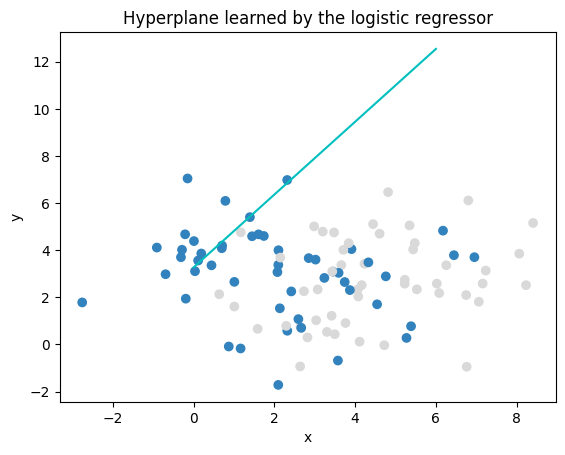

In [86]:
r = -weights[0].item() / weights[1].item()  # slope
t = -bias.item() / weights[1].item()  # intercept

plt.scatter(Xn[:,0], Xn[:,1], c=yn, cmap='tab20c')
plt.title(f"Hyperplane learned by the logistic regressor")
plt.xlabel("x")
plt.ylabel("y")
x_hyperplane = np.linspace(0,6,100)
y_hyperplane = r*x_hyperplane+t
plt.plot(x_hyperplane, y_hyperplane, '-c')  # -c means solid cyan line
plt.show()